{'number_density': <Quantity 1.0 1 / cm3>, 'temperature': <Quantity 1.0 K>, 'density': <Quantity 0.035268224298483024 solMass / pc3>, 'magnetic_field': <Quantity 0.5476852239548456 uG>, 'pressure': <Quantity 2.3869987106358004e-14 erg / cm3>, 'length': <Quantity 1.0 pc>, 'mass': <Quantity 0.03526822429848302 solMass>, 'time': <Quantity 0.9777922216731284 Myr>, 'velocity': <Quantity 1.0 km / s>, 'muH': <Quantity 2.3869987106358e-24 g>, 'gravitational_potential': <Quantity 1.0 km2 / s2>}
14
250
280
310
340
370
400
430


<Figure size 1044x504 with 0 Axes>

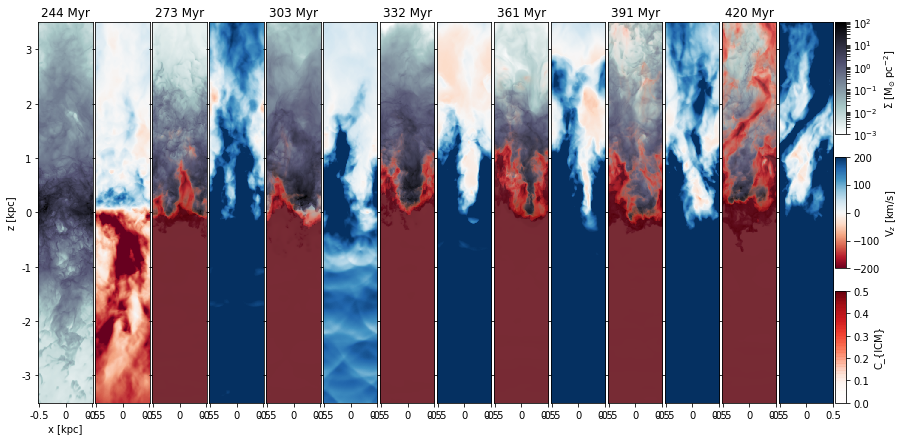

14
250
280


KeyboardInterrupt: 

In [92]:
import matplotlib.pyplot as plt
import os
from shutil import copyfile
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
import sys
import pyathena as pa
import matplotlib.gridspec as gridspec
from mpl_toolkits import axes_grid1
from matplotlib.colors import LogNorm,SymLogNorm,NoNorm,Normalize

from matplotlib.colors import LogNorm
from six.moves import cPickle as pickle

# In[7]:
import matplotlib as mpl


# In[8]:

basedir = 'D:/yeongu/'
#simid = 'MHD_8pc_new' # 'MHD_8pc_new' , 'RPS_8pc_n1e-4_v1414' , 'RPS_8pc_n2e-4_v1414'

# ## Unit system
#
# The unit system we choose for this simulation is
# * [length] = pc
# * [velocity] = km/s
# * [density] = 1.4271*m_h/cm^3

# In[9]:

# You can retrive the unit system with pa.set_units function.
# To make unit conversion easier, I use astropy's unit and constant.
# You may need to install astropy to use it
# please visit http://www.astropy.org/

unit = pa.set_units(muH=1.4271)
print(unit)
#print (unit['density'].cgs / 1.4271 / c.m_p.cgs, unit['velocity'], unit['length'])
#print unit['density']
kb = 1.3806504 * 1e-16 #boltzmann constant erg/K
vpc = 7168.*1024*1024/(128*128*896) # volume per cell


# other units can be easily obtained
# print (unit['mass'], unit['time'], unit['magnetic_field'], unit['temperature'])

# ## Read Full data cube
#
# Original data cube is stored in "vtk" files. For the MPI simulations, Athena dumps the same number of vtk files with the number of proccessors. Each vtk file has data for all physical variables for a part of the simulation "domain" (it is called "grid"). I wrote a reader to read each grid, get data from it, and merge into a big data array for full domain.

stop = 501

simid_t = ('RPS_8pc_noICM_newacc','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2_newacc') # 'MHD_8pc_new' ,
labell = ('No ICM','ICM00','ICM0','ICM1','ICM2','ICM3','ICM4') # r'No ICM',
labelll = ('Cold','Unstable','Warm','Ionized','Hot')
C = ('goldenrod','royalblue','firebrick')
C2 = ('darkblue','deepskyblue','goldenrod','red','firebrick')
C3 = ('darkred','red','salmon')
S = (':','--','-')

# overplot Starformation rate of three different simulations
plt.clf()
for j in (1,0,2) :
    basedir = 'F:/yeongu/'
    if j==2:
        basedir='D:/yeongu/'
        
    simid = simid_t[j]
    Mom_up = []
    ttidx = range(250,450,30)
    k=0
    nsurf=2*len(ttidx)
    print nsurf
    fig=plt.figure(figsize=(nsurf+0.5,7))
    #fig=plt.figure(0,figsize=(ix*nsurf+0.5,iz))
    width_list=[1]*nsurf+[0.2]
    gs = gridspec.GridSpec(3,nsurf+1,width_ratios=width_list,wspace=0.01)
    
    cicm=plt.cm.Reds
    cicm._init()
    print cicm
    x=np.arange(cicm.N)
    alphas=0.4*(np.tanh((x-100)/50.)+1)
    #alphas = np.linspace(0.5, 0.5, cicm.N)
    cicm._lut[:-3,-1] = alphas
    cicm._lut[-3,-1] = alphas.min()
    cicm._lut[-2,-1] = alphas.max()
    clim_icm=(0.0,0.5)
    norm_icm=Normalize()
    
    for tidx in ttidx:  # time step 251, 331, 411, 501
        #plt.figure(figsize=(2.5,7))
        #surf = ('{}{}/surf/{}.{:04d}.surf.p'.format(basedir,simid,simid,tidx))
        vtkfname = '%s%s/id0/%s.%04d.vtk' % (basedir, simid, simid, tidx)
        # read in domain information
        ds = pa.AthenaDataSet(vtkfname)
        #surff = pickle.load(open(surf,'rb'))
        #print surff

        # name of original data fields we stored from the simulation
        #print(ds.field_list)

        # It also has predefined data fields can be calculated from the original data.
        #print(ds.derived_field_list)

        d = ds.read_all_data('density')*unit['density'].value # density
        vel = ds.read_all_data('velocity')
        vel_z = vel[:,:,:,2]
        
        d2 = np.sum(d,axis=1)*8
        vz = np.mean(vel_z,axis=1)
        if j!=0:
            scalar = ds.read_all_data('specific_scalar3')
            icm = np.mean(scalar,axis=1)
        
        axes=fig.axes[:nsurf]
        ax1=plt.subplot(gs[:,2*k])
        im1=ax1.imshow(d2,origin='lower',cmap='bone_r',norm=LogNorm())
        
        if j!=0:
            im11=ax1.imshow(icm,origin='lower',norm=norm_icm)
            im11.set_cmap(cicm)
            im11.set_clim(clim_icm)
        
        plt.xticks([1,64,127],['-0.5','0','0.5'])
        plt.yticks([64,192,320,448,576,704,832],[])
        if k==0:
            plt.yticks([64,192,320,448,576,704,832],['-3', '-2', '-1', '0', '1', '2', '3'])
            plt.ylabel(r'z [kpc]')
            plt.xlabel(r'x [kpc]')
        if (2*k)%2==0:
            plt.title('%s Myr' % int(tidx*unit['time'].value) )
        
        
        ax2=plt.subplot(gs[:,2*k+1])
        im2=ax2.imshow(vz,origin='lower',cmap='RdBu') #cmap='ocean'
        plt.xticks([1,64,127],['-0.5','0','0.5'])
        plt.yticks([64,192,320,448,576,704,832],[])
        

        k = k+1
        print tidx
        im1.set_clim(1e-3,1e2)
        im2.set_clim(-200,200)
        
    cax1 = plt.subplot(gs[0,nsurf])
    cbar1 = plt.colorbar(im1,cax=cax1,label=r'$\Sigma$ [M$_{\odot}$ pc$^{-2}$]')
    cax2 = plt.subplot(gs[1,nsurf])
    cbar2 = plt.colorbar(im2,cax=cax2,label=r'V$_z$ [km/s]',ticks=[-200,-100,0,100,200])
    cax3 = plt.subplot(gs[2,nsurf])
    cbar3 = plt.colorbar(im11,cax=cax3,label=r'C_{ICM}')#,label=r'V$_z$ [km/s]',ticks=[-200,-100,0,100,200])
    
        #plt.setp(axes,'xlim',(x0,x0+Lx))
        #plt.setp(axes,'ylim',(y0,y0+Lz))
        
        
        #plt.subplots_adjust(wspace=.05)
    plt.tight_layout()
    
    #plt.savefig('D:/yeongu/plots/proj_testt.png')
    plt.show()